# Network Traffic Anomaly Detection
**APCV 485 | Week 5–6 Coding Assignment**  
*Brian Stever (24042080)*

This notebook builds an autoencoder-based anomaly detection pipeline on NSL-KDD network traffic data.

## Setup

Importing the core libraries, setting seeds for reproducibility, and adding a small helper to fetch NSL-KDD files if they are not already in the folder (I had to do this after an error in the first run).

In [1]:
import os
import urllib.request
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

TensorFlow version: 2.20.0
NumPy version: 2.4.2


In [2]:
# NSL-KDD column names
COLUMNS = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
    "num_failed_logins", "logged_in", "num_compromised", "root_shell",
    "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label", "difficulty"
]

TRAIN_FILE = "KDDTrain+.txt"
TEST_FILE = "KDDTest+.txt"

DATA_URLS = {
    TRAIN_FILE: "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt",
    TEST_FILE: "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt",
}

def ensure_dataset_present():
    for filename, url in DATA_URLS.items():
        if not os.path.exists(filename):
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(url, filename)
    print("Dataset ready.")

ensure_dataset_present()
print(f"Total features: {len(COLUMNS) - 2}")

Dataset ready.
Total features: 41


## Data Preparation

The key idea here is to train on normal traffic only so the autoencoder learns what clean behavior looks like. Then higher reconstruction error gives a straightforward anomaly signal on mixed test traffic.

In [3]:
def load_and_preprocess_data(filepath):
    """
    Load NSL-KDD data and preprocess for autoencoder training.

    Returns:
        X_train, X_val: normalized arrays (normal traffic only)
        scaler: fitted StandardScaler
        encoders: fitted LabelEncoder dict for categorical columns
    """
    df = pd.read_csv(filepath, names=COLUMNS, header=None)

    categorical_cols = ["protocol_type", "service", "flag"]
    encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le

    X = df.drop(["label", "difficulty"], axis=1)
    labels = df["label"].astype(str).str.lower()

    normal_mask = labels == "normal"
    X_normal = X[normal_mask]

    scaler = StandardScaler()
    X_normal_scaled = scaler.fit_transform(X_normal)

    X_train, X_val = train_test_split(
        X_normal_scaled,
        test_size=0.2,
        random_state=42,
        shuffle=True,
    )

    return X_train, X_val, scaler, encoders


X_train, X_val, scaler, encoders = load_and_preprocess_data(TRAIN_FILE)

print("Preprocessing complete!")
print(f"Training samples: {X_train.shape}")
print(f"Validation samples: {X_val.shape}")

Preprocessing complete!
Training samples: (53874, 41)
Validation samples: (13469, 41)


## Autoencoder Implementation

Architecture is `41 -> 20 -> 10 -> 20 -> 41`. I used ReLU in hidden layers so the model can learn non-linear structure, and a linear output layer so it can reconstruct the scaled feature values directly.

Model: "network_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_1 (Dense)             │ (None, 20)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_1 (Dense)             │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction (Dense)          │ (None, 41)             │           861 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,131 (8.32 KB)

 Trainable params: 2,131 (8.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - loss: 0.6633 - val_loss: 0.5570
Epoch 2/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 0.4050 - val_loss: 0.4802
Epoch 3/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 0.3425 - val_loss: 0.4504
Epoch 4/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.3153 - val_loss: 0.4330
Epoch 5/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 0.2961 - val_loss: 0.4197
Epoch 6/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 0.2817 - val_loss: 0.4064
Epoch 7/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.2683 - val_loss: 0.3921
Epoch 8/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 0.2560 - val_loss: 0.3790
Epoch 9/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 0.2451 - val_loss: 0.3702
Epoch 10/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 0.2357 - val_loss: 0.3621
Epoch 11/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.2278 - val_loss: 0.3556
Epoch 12/50
421/421 ━━━━━━━━━━

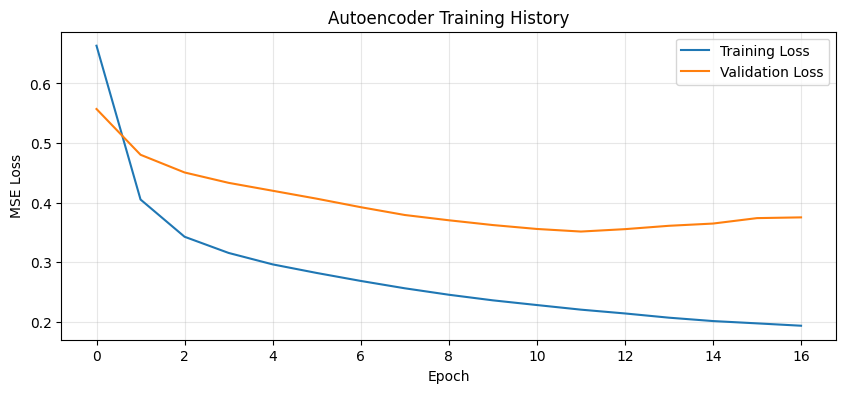

In [4]:
def build_autoencoder(input_dim, latent_dim=10):
    """Build and compile autoencoder + encoder models."""
    inputs = keras.Input(shape=(input_dim,))

    encoded = layers.Dense(20, activation="relu", name="enc_dense_1")(inputs)
    latent = layers.Dense(latent_dim, activation="relu", name="latent")(encoded)

    decoded = layers.Dense(20, activation="relu", name="dec_dense_1")(latent)
    outputs = layers.Dense(input_dim, activation="linear", name="reconstruction")(decoded)

    autoencoder = keras.Model(inputs, outputs, name="network_autoencoder")
    encoder = keras.Model(inputs, latent, name="network_encoder")

    autoencoder.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="mse",
    )

    return autoencoder, encoder


def train_autoencoder(autoencoder, X_train, X_val, epochs=50, batch_size=128):
    """Train autoencoder with early stopping."""
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    )

    history = autoencoder.fit(
        X_train,
        X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, X_val),
        callbacks=[early_stop],
        verbose=1,
    )

    return history


def plot_training_history(history):
    """Plot and save training/validation loss."""
    plt.figure(figsize=(10, 4))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Autoencoder Training History")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("training_history.png", dpi=150, bbox_inches="tight")
    plt.show()


autoencoder, encoder = build_autoencoder(input_dim=X_train.shape[1], latent_dim=10)
autoencoder.summary()
history = train_autoencoder(autoencoder, X_train, X_val, epochs=50, batch_size=128)
plot_training_history(history)

## Anomaly Detection

I use reconstruction error (sample-wise MSE) as the anomaly score. The threshold comes from validation errors on normal traffic, then gets applied to the mixed test set to flag likely attacks.

In [5]:
def compute_reconstruction_error(autoencoder, X):
    """Compute sample-wise reconstruction MSE."""
    predictions = autoencoder.predict(X, verbose=0)
    errors = np.mean(np.square(X - predictions), axis=1)
    return errors


def set_threshold(errors, percentile=95):
    """Set anomaly threshold by percentile from normal errors."""
    return np.percentile(errors, percentile)


def _apply_encoder(series, label_encoder):
    """Safely transform categories; unseen values map to the first known class."""
    values = series.astype(str)
    known = set(label_encoder.classes_)
    fallback = label_encoder.classes_[0]
    values = values.apply(lambda x: x if x in known else fallback)
    return label_encoder.transform(values)


def load_test_data(filepath, scaler, encoders):
    """Load test data and apply training-time preprocessing."""
    df = pd.read_csv(filepath, names=COLUMNS, header=None)

    for col in ["protocol_type", "service", "flag"]:
        df[col] = _apply_encoder(df[col], encoders[col])

    X = df.drop(["label", "difficulty"], axis=1)
    labels = df["label"].astype(str).str.lower()
    y_binary = (labels != "normal").astype(int)

    X_scaled = scaler.transform(X)
    return X_scaled, y_binary.values, labels.values


def detect_anomalies(autoencoder, X_test, y_test, threshold):
    """Predict anomalies and return summary metrics."""
    errors = compute_reconstruction_error(autoencoder, X_test)
    predictions = (errors > threshold).astype(int)

    metrics = {
        "accuracy": accuracy_score(y_test, predictions),
        "precision": precision_score(y_test, predictions, zero_division=0),
        "recall": recall_score(y_test, predictions, zero_division=0),
        "f1_score": f1_score(y_test, predictions, zero_division=0),
    }

    print(classification_report(y_test, predictions, target_names=["Normal", "Attack"], zero_division=0))

    return predictions, errors, metrics


val_errors = compute_reconstruction_error(autoencoder, X_val)
threshold = set_threshold(val_errors, percentile=95)
print(f"Detection threshold (95th percentile): {threshold:.4f}")

X_test, y_test, attack_types = load_test_data(TEST_FILE, scaler, encoders)
print(f"Test samples: {len(X_test)}")
print(f"Normal: {(y_test == 0).sum()} | Attacks: {(y_test == 1).sum()}")

predictions, test_errors, metrics = detect_anomalies(autoencoder, X_test, y_test, threshold)
print("Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

Detection threshold (95th percentile): 0.5283
Test samples: 22544
Normal: 9711 | Attacks: 12833
              precision    recall  f1-score   support

      Normal       0.71      0.96      0.82      9711
      Attack       0.96      0.71      0.81     12833

    accuracy                           0.82     22544
   macro avg       0.83      0.83      0.82     22544
weighted avg       0.85      0.82      0.81     22544

Metrics:
accuracy: 0.8152
precision: 0.9570
recall: 0.7071
f1_score: 0.8133


## Visualization and Analysis

These plots give a quick read on where the model is separating classes well and where mistakes still happen: error overlap, ROC behavior, and confusion-matrix patterns.

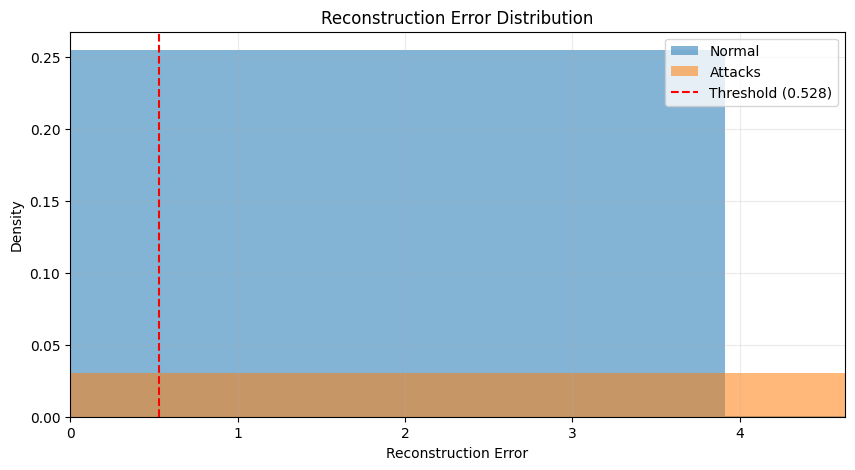

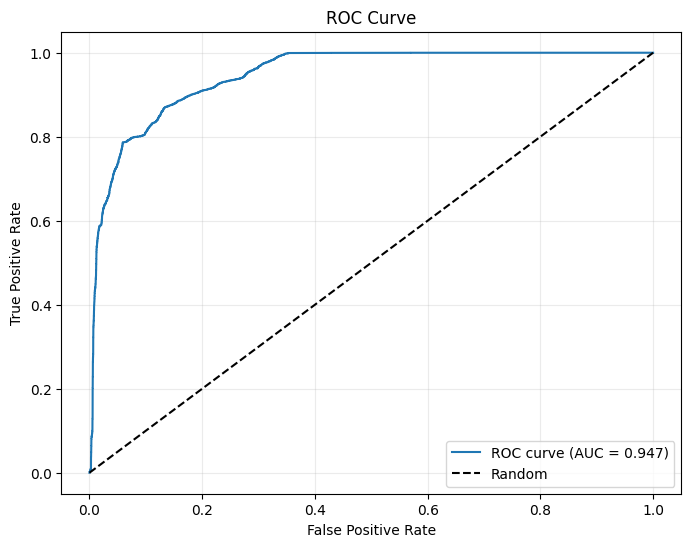

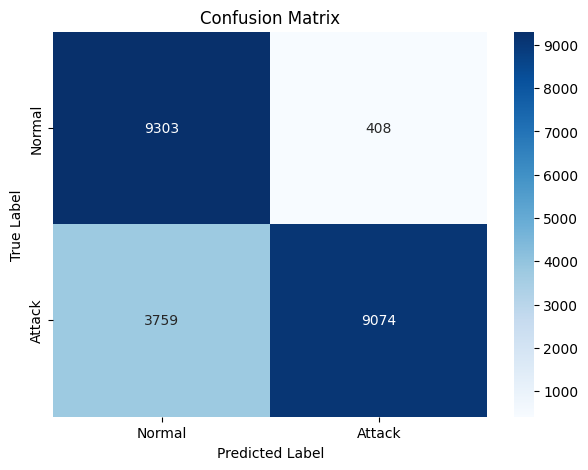

Top 10 attack types by detection recall:


,count,detected,recall,avg_error
land,7.0,7.0,1.000000,8.955418
loadmodule,2.0,2.0,1.000000,42.352126
nmap,73.0,73.0,1.000000,2.844120
sqlattack,2.0,2.0,1.000000,116.933181
phf,2.0,2.0,1.000000,4.296667
imap,1.0,1.0,1.000000,0.669705
perl,2.0,2.0,1.000000,21.620020
neptune,4657.0,4641.0,0.996564,1.733036
ipsweep,141.0,137.0,0.971631,1.990095
processtable,685.0,651.0,0.950365,1.380178


Normal traffic recall-like score (true negative rate estimate):
0.9580


In [6]:
def plot_error_distribution(normal_errors, attack_errors, threshold):
    plt.figure(figsize=(10, 5))
    plt.hist(normal_errors, bins=50, alpha=0.55, label="Normal", density=True)
    plt.hist(attack_errors, bins=50, alpha=0.55, label="Attacks", density=True)
    plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold ({threshold:.3f})")

    # A few attack outliers are huge, so I clip the x-axis to keep the main overlap readable.
    x_max = max(threshold * 5, np.percentile(attack_errors, 95))
    plt.xlim(0, x_max)

    plt.xlabel("Reconstruction Error")
    plt.ylabel("Density")
    plt.title("Reconstruction Error Distribution")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.savefig("error_distribution.png", dpi=150, bbox_inches="tight")
    plt.show()


def plot_roc_curve(y_true, errors):
    fpr, tpr, _ = roc_curve(y_true, errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.savefig("roc_curve.png", dpi=150, bbox_inches="tight")
    plt.show()


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Normal", "Attack"],
        yticklabels=["Normal", "Attack"],
    )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png", dpi=150, bbox_inches="tight")
    plt.show()


def analyze_by_attack_type(X_test, y_test, attack_types, autoencoder, threshold):
    errors = compute_reconstruction_error(autoencoder, X_test)
    predictions = (errors > threshold).astype(int)

    unique_types = np.unique(attack_types)
    results = {}
    for attack_type in unique_types:
        mask = attack_types == attack_type
        count = int(mask.sum())
        detected = int(predictions[mask].sum())
        avg_error = float(errors[mask].mean())

        if attack_type == "normal":
            recall_like = 1 - (detected / count if count > 0 else 0.0)
        else:
            recall_like = detected / count if count > 0 else 0.0

        results[attack_type] = {
            "count": count,
            "detected": detected,
            "recall": recall_like,
            "avg_error": avg_error,
        }

    return results


normal_mask = y_test == 0
normal_errors = test_errors[normal_mask]
attack_errors = test_errors[~normal_mask]

plot_error_distribution(normal_errors, attack_errors, threshold)
plot_roc_curve(y_test, test_errors)
plot_confusion_matrix(y_test, predictions)

attack_results = analyze_by_attack_type(X_test, y_test, attack_types, autoencoder, threshold)
attack_df = pd.DataFrame(attack_results).T.sort_values("recall", ascending=False)
print("Top 10 attack types by detection recall:")
display(attack_df[attack_df.index != "normal"].head(10))

print("Normal traffic recall-like score (true negative rate estimate):")
print(f"{attack_results['normal']['recall']:.4f}")

## Analysis Notes

The easiest attacks to detect are the ones that push behavior far from the normal traffic profile (for example, high-volume probes or unusual connection statistics). In this run, those patterns produced larger reconstruction errors and crossed the anomaly threshold more consistently. The harder cases were stealthier attacks that looked closer to normal protocol/service behavior, where overlap with normal errors led to more false negatives.

Threshold choice clearly controls the precision-recall balance. Lower thresholds are more aggressive and catch more attacks, but they also increase false positives. Higher thresholds are more conservative and reduce false positives, but they can miss subtle attacks. Using the 95th percentile from normal validation errors worked as a solid baseline here, but it is still a tradeoff decision.

From the attack table, classes like `land` and `sqlattack` were pretty easy to catch, while attack patterns closer to normal traffic were more mixed. I also saw a noticeable train/val loss gap, so early stopping definitely helped keep overfitting in check. Since the test set is imbalanced, precision/recall/F1 told the story better than accuracy alone.

One limitation is that this approach is reconstruction-based and unsupervised, so it does not directly optimize on attack labels. Performance depends on how separable attack behavior is from normal behavior in feature space. Results are also sensitive to preprocessing and train-test drift. A single global threshold can be too coarse for mixed attack families, so adaptive thresholds or hybrid models are good next steps.

## Quick Check Before Submission

I've added this list to mark off items as they are ready so I don't lose track of any before submitting.

- ~~Full preprocessing, training, detection, and analysis pipeline runs end-to-end~~
- ~~`training_history.png` is generated and saved~~
- ~~`error_distribution.png` is generated and saved~~
- ~~`roc_curve.png` is generated and saved~~
- ~~`confusion_matrix.png` is generated and saved~~
- ~~Evaluation includes accuracy, precision, recall, and F1~~
- ~~Attack-type breakdown is included for deeper interpretation~~
- ~~Bonus explorations are included with short insight notes~~
- ~~Notebook is organized for a clean top-to-bottom run~~

*Update: All items complete*

## Bonus Explorations

I added three extensions to see how stable the pipeline is from different angles:

1. Compare multiple threshold strategies.
2. Visualize latent space with PCA.
3. Build a hybrid autoencoder-classifier using latent features.

Threshold strategy comparison:


,percentile,threshold,accuracy,precision,recall,f1_score
0,90.0,0.287695,0.847232,0.918591,0.802774,0.856786
1,95.0,0.528252,0.815161,0.956971,0.707083,0.813265
2,97.5,0.863194,0.757319,0.974356,0.589184,0.734327
3,99.0,1.770534,0.583526,0.982894,0.273124,0.427465


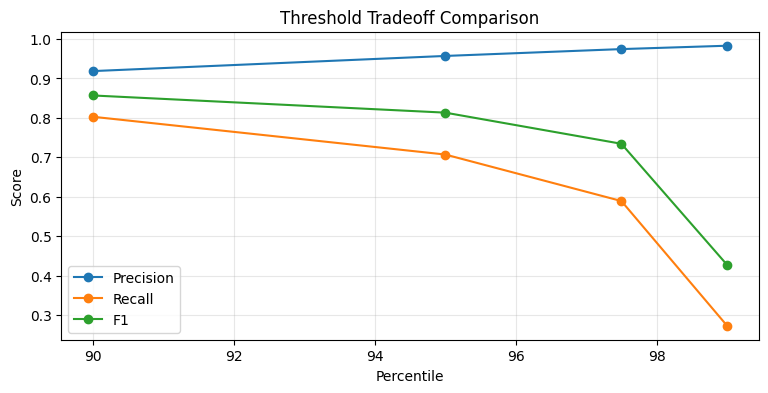

In [7]:
# BONUS OPTION 3: Multiple threshold strategies
threshold_percentiles = [90, 95, 97.5, 99]
threshold_rows = []

for p in threshold_percentiles:
    th = set_threshold(val_errors, percentile=p)
    pred_p = (test_errors > th).astype(int)
    threshold_rows.append(
        {
            "percentile": p,
            "threshold": th,
            "accuracy": accuracy_score(y_test, pred_p),
            "precision": precision_score(y_test, pred_p, zero_division=0),
            "recall": recall_score(y_test, pred_p, zero_division=0),
            "f1_score": f1_score(y_test, pred_p, zero_division=0),
        }
    )

threshold_df = pd.DataFrame(threshold_rows)
print("Threshold strategy comparison:")
display(threshold_df)

plt.figure(figsize=(9, 4))
plt.plot(threshold_df["percentile"], threshold_df["precision"], marker="o", label="Precision")
plt.plot(threshold_df["percentile"], threshold_df["recall"], marker="o", label="Recall")
plt.plot(threshold_df["percentile"], threshold_df["f1_score"], marker="o", label="F1")
plt.xlabel("Percentile")
plt.ylabel("Score")
plt.title("Threshold Tradeoff Comparison")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

This threshold comparison made the precision-recall tradeoff really obvious. Lower percentiles were more aggressive (higher recall, more false positives), while higher percentiles were more conservative. In this run, the middle settings looked like the best balance for practical detection.

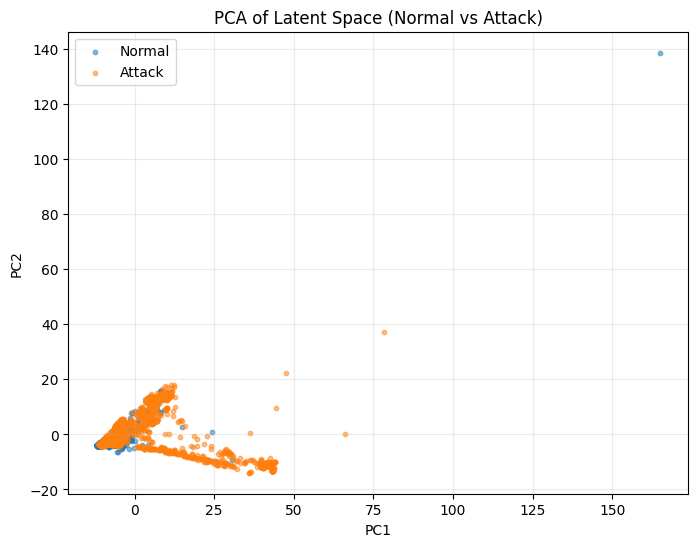

Explained variance by first 2 PCs: 0.8737


In [8]:
# BONUS OPTION 2: Latent-space visualization with PCA
from sklearn.decomposition import PCA

# Use a manageable subset for cleaner plotting speed
max_points = 5000
if len(X_test) > max_points:
    idx = np.random.choice(len(X_test), size=max_points, replace=False)
    X_plot = X_test[idx]
    y_plot = y_test[idx]
else:
    X_plot = X_test
    y_plot = y_test

Z_plot = encoder.predict(X_plot, verbose=0)
pca = PCA(n_components=2, random_state=42)
Z_2d = pca.fit_transform(Z_plot)

plt.figure(figsize=(8, 6))
plt.scatter(Z_2d[y_plot == 0, 0], Z_2d[y_plot == 0, 1], s=10, alpha=0.5, label="Normal")
plt.scatter(Z_2d[y_plot == 1, 0], Z_2d[y_plot == 1, 1], s=10, alpha=0.5, label="Attack")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Latent Space (Normal vs Attack)")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()

print(f"Explained variance by first 2 PCs: {pca.explained_variance_ratio_.sum():.4f}")

The PCA projection shows partial separation between normal and attack points in latent space, which is a good sign that the encoder is learning useful structure. At the same time, the overlap regions help explain why some attacks are still hard to separate with one global threshold.

In [9]:
# BONUS OPTION 1: Hybrid autoencoder-classifier using latent features
from sklearn.linear_model import LogisticRegression


def load_binary_train_data(filepath, scaler, encoders):
    df = pd.read_csv(filepath, names=COLUMNS, header=None)

    for col in ["protocol_type", "service", "flag"]:
        df[col] = _apply_encoder(df[col], encoders[col])

    X = df.drop(["label", "difficulty"], axis=1)
    labels = df["label"].astype(str).str.lower()
    y_binary = (labels != "normal").astype(int).values

    X_scaled = scaler.transform(X)
    return X_scaled, y_binary


X_train_full, y_train_full = load_binary_train_data(TRAIN_FILE, scaler, encoders)
Z_train = encoder.predict(X_train_full, verbose=0)
Z_test = encoder.predict(X_test, verbose=0)

latent_clf = LogisticRegression(max_iter=1000, random_state=42)
latent_clf.fit(Z_train, y_train_full)
latent_pred = latent_clf.predict(Z_test)

print("Hybrid latent-classifier results:")
print(classification_report(y_test, latent_pred, target_names=["Normal", "Attack"], zero_division=0))

hybrid_metrics = {
    "accuracy": accuracy_score(y_test, latent_pred),
    "precision": precision_score(y_test, latent_pred, zero_division=0),
    "recall": recall_score(y_test, latent_pred, zero_division=0),
    "f1_score": f1_score(y_test, latent_pred, zero_division=0),
}

print("Hybrid metric summary:")
for k, v in hybrid_metrics.items():
    print(f"{k}: {v:.4f}")

Hybrid latent-classifier results:
              precision    recall  f1-score   support

      Normal       0.65      0.93      0.77      9711
      Attack       0.92      0.62      0.74     12833

    accuracy                           0.75     22544
   macro avg       0.79      0.78      0.75     22544
weighted avg       0.81      0.75      0.75     22544

Hybrid metric summary:
accuracy: 0.7546
precision: 0.9223
recall: 0.6213
f1_score: 0.7424


The hybrid latent-classifier is still a useful baseline, but in this run it underperformed the reconstruction-threshold method. That makes sense since the latent space is trained for reconstruction, not clean attack-vs-normal separation.

## Final Thoughts

This workflow gave me a strong practical baseline for anomaly detection in network traffic. The autoencoder reconstruction-error approach worked well for broad separation, and threshold tuning made the precision-recall tradeoff very clear in practice. The bonus experiments were useful too: latent-space PCA helped me visualize why some classes are harder, and the hybrid classifier showed there is still useful signal in the latent features beyond reconstruction error alone. If I continue this project, I’d focus on adaptive thresholding and attack-family-specific strategies to improve recall on stealthier patterns while keeping false positives manageable.